## ***Assignment 2***

In [ ]:
import torch
torch.cuda.empty_cache()

#### ***Import neccessary libraries and load the ratings***

In [1]:
import pandas as pd
import numpy as np

# Cargar ratings
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
print("Ratings:", ratings.head())

# Cargar movies
movies = pd.read_csv('../data/ml-latest-small/movies.csv')
print("Movies:", movies.head())

# Cargar tags
tags = pd.read_csv('../data/ml-latest-small/tags.csv')
print("Tags:", tags.head())

Ratings:    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Movies:    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Tags:    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2 

#### ***Preproccess data***

In [2]:
# Filtrar usuarios y películas con menos de 10 ratings
user_counts = ratings['userId'].value_counts()
ratings = ratings[ratings['userId'].isin(user_counts[user_counts >= 10].index)]

movie_counts = ratings['movieId'].value_counts()
ratings = ratings[ratings['movieId'].isin(movie_counts[movie_counts >= 10].index)]

print("Usuarios después de filtrar:", ratings['userId'].nunique())
print("Películas después de filtrar:", ratings['movieId'].nunique())

# Normalizar ratings a [0, 1]
ratings['rating_norm'] = ratings['rating'] / 5.0

Usuarios después de filtrar: 610
Películas después de filtrar: 2269


**Create mappings for user ID's and films**

In [3]:
unique_user_ids = ratings['userId'].unique()
unique_movie_ids = ratings['movieId'].unique()

userId_to_index = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
movieId_to_index = {movie_id: idx for idx, movie_id in enumerate(unique_movie_ids)}

ratings['userIndex'] = ratings['userId'].map(userId_to_index)
ratings['movieIndex'] = ratings['movieId'].map(movieId_to_index)

**Get the movie genres vector**

In [4]:
# Función para obtener todos los géneros
def get_all_genres(movies_df):
    genres_set = set()
    for genres in movies_df['genres']:
        for genre in genres.split("|"):
            genres_set.add(genre)
    return list(genres_set)

all_genres = get_all_genres(movies)
genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}
num_genres = len(all_genres)

# Función para codificar los géneros en un vector one-hot
def encode_genres(genres_str, genre_to_index, num_genres):
    vec = np.zeros(num_genres, dtype=np.float32)
    for genre in genres_str.split("|"):
        if genre in genre_to_index:
            vec[genre_to_index[genre]] = 1.0
    return vec

# Agregar la columna 'genres_vector' al DataFrame movies
movies['genres_vector'] = movies['genres'].apply(lambda x: encode_genres(x, genre_to_index, num_genres))

**Procesar tags CSV para obtener un vector de características de tags**

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Agrupar los tags por movieId y concatenar todos los tags en un único string
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: " ".join(x.astype(str))).reset_index()

# Vectorizar el texto usando TF-IDF (limita el número de características, por ejemplo, a 100)
vectorizer = TfidfVectorizer(max_features=100)
tags_tfidf = vectorizer.fit_transform(tags_grouped['tag'])

# Reducir dimensionalidad a un vector de tamaño fijo (por ejemplo, 32)
svd = TruncatedSVD(n_components=32, random_state=42)
tags_reduced = svd.fit_transform(tags_tfidf)

# Crear un DataFrame con estas features
tags_features_df = pd.DataFrame(tags_reduced, columns=[f'tag_feat_{i}' for i in range(32)])
tags_features_df['movieId'] = tags_grouped['movieId']

# Opcional: Crear una columna que contenga la lista de features
tags_features_df['tag_features'] = tags_features_df[[f'tag_feat_{i}' for i in range(32)]].values.tolist()
print("Tags features:", tags_features_df[['movieId', 'tag_features']].head())

Tags features:    movieId                                       tag_features
0        1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        2  [0.0011784274794497075, 0.0015045311115500077,...
2        3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        5  [3.799389512103565e-07, 0.0004486458541472698,...
4        7  [3.799389512103565e-07, 0.0004486458541472698,...


**Merge and export**

In [6]:
# Fusionar ratings con movies (para obtener genres_vector)
merged_df = ratings.merge(movies[['movieId', 'genres_vector']], on='movieId', how='left')

# Fusionar con los tags: solo tomamos movieId y tag_features
merged_df = merged_df.merge(tags_features_df[['movieId', 'tag_features']], on='movieId', how='left')

print("Dataset fusionado:")
print(merged_df.head())

Dataset fusionado:
   userId  movieId  rating  timestamp  rating_norm  userIndex  movieIndex  \
0       1        1     4.0  964982703          0.8          0           0   
1       1        3     4.0  964981247          0.8          0           1   
2       1        6     4.0  964982224          0.8          0           2   
3       1       47     5.0  964983815          1.0          0           3   
4       1       50     5.0  964982931          1.0          0           4   

                                       genres_vector  \
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   

                                        tag_features  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2               

In [7]:
merged_df.to_csv('../data/final_merged_dataset.csv', index=False)
print("Dataset exportado como '../data/final_merged_dataset.csv'")

Dataset exportado como '../data/final_merged_dataset.csv'


#### ***Personalized Dataset***

In [8]:
import torch
from torch.utils.data import Dataset

class MovieLensDataset(Dataset):
    def __init__(self, users, movies, ratings, movie_features, tag_features):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        self.movie_features = movie_features  # Vector de géneros
        self.tag_features = tag_features        # Vector de tags
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return {
            'user': self.users[idx],
            'movie': self.movies[idx],
            'rating': self.ratings[idx],
            'movie_features': self.movie_features[idx],
            'tag_features': self.tag_features[idx]
        }

#### ***Train Test Split***

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Suponiendo que 'merged_df' es tu DataFrame fusionado (ratings + movies + tags)
# Opcional: filtrar a usuarios con al menos 3 ratings
user_counts = merged_df['userId'].value_counts()
merged_filtered = merged_df[merged_df['userId'].isin(user_counts[user_counts >= 3].index)]

# Dividir los datos por usuario para evitar que un mismo usuario aparezca en más de una partición
train_list = []
val_list = []
test_list = []

for user_id, group in merged_filtered.groupby('userId'):
    # 70% para entrenamiento, 30% para temp
    user_train, user_temp = train_test_split(group, test_size=0.30, random_state=42)
    # Del 30% restante, 50% para validación y 50% para test (es decir, 15% cada uno)
    user_val, user_test = train_test_split(user_temp, test_size=0.50, random_state=42)
    train_list.append(user_train)
    val_list.append(user_val)
    test_list.append(user_test)

train_data = pd.concat(train_list).reset_index(drop=True)
val_data   = pd.concat(val_list).reset_index(drop=True)
test_data  = pd.concat(test_list).reset_index(drop=True)

print("Train size:", len(train_data))
print("Validation size:", len(val_data))
print("Test size:", len(test_data))

Train size: 56505
Validation size: 12164
Test size: 12447


In [10]:
import ast

def get_fixed_tag_features(x, length=32):
    # Si x es una cadena, intenta evaluarla a lista
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except Exception:
            x = []
    # Asegurarse de que x sea una lista
    if not isinstance(x, list):
        x = []
    # Si la lista es más corta, se rellena con ceros; si es más larga, se trunca
    if len(x) < length:
        x = x + [0.0] * (length - len(x))
    elif len(x) > length:
        x = x[:length]
    return x

# Aplicar la función a la columna 'tag_features' para el conjunto de entrenamiento
train_data['tag_features'] = train_data['tag_features'].apply(lambda x: get_fixed_tag_features(x, 32))
# Hacer lo mismo para validación y test si es necesario
val_data['tag_features'] = val_data['tag_features'].apply(lambda x: get_fixed_tag_features(x, 32))
test_data['tag_features'] = test_data['tag_features'].apply(lambda x: get_fixed_tag_features(x, 32))

# Ahora sí, puedes stackear las listas sin problemas:
train_tag_features = torch.tensor(np.stack(train_data['tag_features'].values), dtype=torch.float32)

#### ***Dataloaders***

In [11]:
import torch
from torch.utils.data import DataLoader
import numpy as np

# Ejemplo: cargar las columnas necesarias desde el DataFrame 'df'
# Asegúrate de tener las particiones 'train_data', 'val_data' y 'test_data'

# Convertir las columnas a tensores
# Convertir a tensores para la partición de entrenamiento (ejemplo; haz lo mismo para val y test)
train_user = torch.tensor(train_data['userIndex'].values, dtype=torch.long)
train_movie = torch.tensor(train_data['movieIndex'].values, dtype=torch.long)
train_rating = torch.tensor(train_data['rating_norm'].values, dtype=torch.float32)

# Para columnas que contienen listas (asegúrate de que se lean como listas, no strings)
train_movie_features = torch.tensor(np.stack(train_data['genres_vector'].values), dtype=torch.float32)
train_tag_features = torch.tensor(np.stack(train_data['tag_features'].values), dtype=torch.float32)

val_user = torch.tensor(val_data['userIndex'].values, dtype=torch.long)
val_movie = torch.tensor(val_data['movieIndex'].values, dtype=torch.long)
val_rating = torch.tensor(val_data['rating_norm'].values, dtype=torch.float32)
val_movie_features = torch.tensor(np.stack(val_data['genres_vector'].values), dtype=torch.float32)
val_tag_features = torch.tensor(np.stack(val_data['tag_features'].values), dtype=torch.float32)

test_user = torch.tensor(test_data['userIndex'].values, dtype=torch.long)
test_movie = torch.tensor(test_data['movieIndex'].values, dtype=torch.long)
test_rating = torch.tensor(test_data['rating_norm'].values, dtype=torch.float32)
test_movie_features = torch.tensor(np.stack(test_data['genres_vector'].values), dtype=torch.float32)
test_tag_features = torch.tensor(np.stack(test_data['tag_features'].values), dtype=torch.float32)


batch_size = 512

train_dataset = MovieLensDataset(train_user, train_movie, train_rating, train_movie_features, train_tag_features)
val_dataset = MovieLensDataset(val_user, val_movie, val_rating, val_movie_features, val_tag_features)
test_dataset = MovieLensDataset(test_user, test_movie, test_rating, test_movie_features, test_tag_features)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#### ***Red Neuronal***

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralCollaborativeFilteringWithTags(nn.Module):
    def __init__(self, num_users, num_movies, genre_input_dim, tag_input_dim,
                 embedding_dim=64, genre_emb_dim=32, tag_emb_dim=16, dropout_rate=0.3):
        super(NeuralCollaborativeFilteringWithTags, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        
        # Capa para transformar el vector de géneros
        self.genre_layer = nn.Linear(genre_input_dim, genre_emb_dim)
        # Capa para transformar el vector de tags
        self.tag_layer = nn.Linear(tag_input_dim, tag_emb_dim)
        
        # Concatenación de: user_embedding, movie_embedding, genre_embedded y tag_embedded
        input_dim = embedding_dim * 2 + genre_emb_dim + tag_emb_dim
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, user, movie, movie_features, tag_features):
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        genre_embedded = F.relu(self.genre_layer(movie_features))
        tag_embedded = F.relu(self.tag_layer(tag_features))
        
        x = torch.cat([user_embedded, movie_embedded, genre_embedded, tag_embedded], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.output_layer(x)
        return out.squeeze()

#### ***Red Neuronal***

In [13]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_users = len(userId_to_index)
num_movies = len(movieId_to_index)
# 'num_genres' es el número de géneros; 'tag_input_dim' es 32 (según la reducción de SVD)
model = NeuralCollaborativeFilteringWithTags(num_users=num_users,
                                              num_movies=num_movies,
                                              genre_input_dim=num_genres,
                                              tag_input_dim=32).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings = batch['rating'].to(device)
        movie_features = batch['movie_features'].to(device)
        tag_features = batch['tag_features'].to(device)
        
        preds = model(users, movies, movie_features, tag_features)
        loss = criterion(preds, ratings)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(ratings)
    
    avg_train_loss = total_loss / len(train_loader.dataset)
    
    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            users = batch['user'].to(device)
            movies = batch['movie'].to(device)
            ratings = batch['rating'].to(device)
            movie_features = batch['movie_features'].to(device)
            tag_features = batch['tag_features'].to(device)
            
            preds = model(users, movies, movie_features, tag_features)
            loss = criterion(preds, ratings)
            val_loss += loss.item() * len(ratings)
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

Epoch 1: Train Loss = 0.1028, Val Loss = 0.0412
Epoch 2: Train Loss = 0.0547, Val Loss = 0.0383
Epoch 3: Train Loss = 0.0498, Val Loss = 0.0374
Epoch 4: Train Loss = 0.0469, Val Loss = 0.0357
Epoch 5: Train Loss = 0.0450, Val Loss = 0.0345
Epoch 6: Train Loss = 0.0433, Val Loss = 0.0341
Epoch 7: Train Loss = 0.0422, Val Loss = 0.0333
Epoch 8: Train Loss = 0.0410, Val Loss = 0.0329
Epoch 9: Train Loss = 0.0400, Val Loss = 0.0324
Epoch 10: Train Loss = 0.0389, Val Loss = 0.0326


In [ ]:
import torch

# Supongamos que 'model' es la instancia entrenada de tu modelo
torch.save(model.state_dict(), "../models/ratings_movies_tags.pth")
print("Model state dictionary saved")

#### ***Evaluation***

In [15]:
import numpy as np
from sklearn.metrics import r2_score

# Se asume que ya tienes 'all_preds' y 'all_truth' obtenidos en el test (desnormalizados a escala original, ej. 0.5-5)
all_preds = []
all_truth = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings = batch['rating'].to(device)
        movie_features = batch['movie_features'].to(device)
        tag_features = batch['tag_features'].to(device)
        preds = model(users, movies, movie_features, tag_features)
        # Desnormalizamos multiplicando por 5 (si esa es la escala original)
        all_preds.extend((preds * 5).cpu().numpy())
        all_truth.extend((ratings * 5).cpu().numpy())

all_preds = np.array(all_preds)
all_truth = np.array(all_truth)

rmse = np.sqrt(np.mean((all_preds - all_truth) ** 2))
mae = np.mean(np.abs(all_preds - all_truth))
r2 = r2_score(all_truth, all_preds)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 0.9111196
MAE: 0.7170114
R2: 0.21510040760040283


In [16]:
from collections import defaultdict
import numpy as np

k = 10
user_preds = defaultdict(list)
user_truth = defaultdict(list)

model.eval()
with torch.no_grad():
    for batch in test_loader:
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings = batch['rating'].to(device)
        movie_features = batch['movie_features'].to(device)
        tag_features = batch['tag_features'].to(device)
        preds = model(users, movies, movie_features, tag_features)
        # Desnormalizamos multiplicando por 5
        for u, pred, true in zip(users.cpu().numpy(), (preds * 5).cpu().numpy(), (ratings * 5).cpu().numpy()):
            user_preds[u].append(pred)
            user_truth[u].append(true)

precisions = []
for u in user_preds:
    preds_u = np.array(user_preds[u])
    truths_u = np.array(user_truth[u])
    # Ordenar índices según las predicciones (descendente)
    top_k_indices = np.argsort(-preds_u)[:k]
    # Consideramos relevante si el rating real es >= 4.0
    relevant = (truths_u >= 4.0)
    num_relevant = np.sum(relevant[top_k_indices])
    precision_u = num_relevant / k
    precisions.append(precision_u)

precision_at_k = np.mean(precisions)
print("Precision@K:", precision_at_k)

Precision@K: 0.5095081967213114


In [17]:
def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    # DCG: usamos la fórmula (2^rel - 1) / log2(pos + 1)
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    # IDCG: orden ideal de relevancias
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

ndcgs = []
for u in user_preds:
    preds_u = np.array(user_preds[u])
    truths_u = np.array(user_truth[u])
    # Convertir a relevancia binaria: 1 si rating >= 4.0, 0 de lo contrario
    relevances = (truths_u >= 4.0).astype(int)
    top_k_indices = np.argsort(-preds_u)[:k]
    ndcg_u = ndcg_at_k(relevances[top_k_indices], k)
    ndcgs.append(ndcg_u)

ndcg_at_k_value = np.mean(ndcgs)
print("NDCG@K:", ndcg_at_k_value)

NDCG@K: 0.8504520655186077


In [18]:
recalls = []
for u in user_preds:
    preds_u = np.array(user_preds[u])
    truths_u = np.array(user_truth[u])
    # Número total de ítems relevantes para el usuario
    total_relevant = np.sum(truths_u >= 4.0)
    if total_relevant == 0:
        continue  # O se podría asignar 0 para este usuario
    top_k_indices = np.argsort(-preds_u)[:k]
    relevant_top_k = np.sum(truths_u[top_k_indices] >= 4.0)
    recall_u = relevant_top_k / total_relevant
    recalls.append(recall_u)

recall_at_k = np.mean(recalls) if recalls else 0.0
print("Recall@K:", recall_at_k)

Recall@K: 0.765738912695276


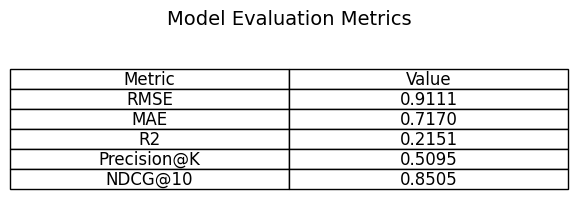

In [19]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

# Suponiendo que ya tienes las variables calculadas:
# rmse, mae, r2, precision_at_k, ndcg_at_k_value

metrics = {
    'RMSE': float(np.round(rmse, 4)),
    'MAE': float(np.round(mae, 4)),
    'R2': float(np.round(r2, 4)),
    'Precision@K': float(np.round(precision_at_k, 4)),
    'NDCG@10': float(np.round(ndcg_at_k_value, 4))
}

# Crear DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
metrics_df['Value'] = metrics_df['Value'].apply(lambda x: f"{x:.4f}")

# Crear la figura y eje para la tabla
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
table = ax.table(cellText=metrics_df.values,
                 colLabels=metrics_df.columns,
                 loc='center',
                 cellLoc='center')

# Ajustes estéticos
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.title("Model Evaluation Metrics", fontsize=14, pad=20)
plt.show()

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from collections import defaultdict
import torch

# Asegúrate de que model_tags está instanciado y se ha definido el dispositivo 'device'
# Cargar el checkpoint (ajusta la ruta según corresponda)
model.eval()

all_preds = []
all_truth = []

with torch.no_grad():
    for batch in test_loader:
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings = batch['rating'].to(device)
        movie_features = batch['movie_features'].to(device)
        tag_features = batch['tag_features'].to(device)
        
        preds = model(users, movies, movie_features, tag_features)
        preds = preds * 5
        ratings = ratings * 5
        
        all_preds.extend(preds.cpu().numpy())
        all_truth.extend(ratings.cpu().numpy())

all_preds = np.array(all_preds)
all_truth = np.array(all_truth)

rmse = np.sqrt(mean_squared_error(all_truth, all_preds))
mae = mean_absolute_error(all_truth, all_preds)
r2 = r2_score(all_truth, all_preds)

k = 10
user_preds = defaultdict(list)
user_truth = defaultdict(list)
with torch.no_grad():
    for batch in test_loader:
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings = batch['rating'].to(device)
        movie_features = batch['movie_features'].to(device)
        tag_features = batch['tag_features'].to(device)
        
        preds = model(users, movies, movie_features, tag_features)
        preds = preds * 5
        ratings = ratings * 5
        
        for u, pred, true in zip(users.cpu().numpy(), preds.cpu().numpy(), ratings.cpu().numpy()):
            user_preds[u].append(pred)
            user_truth[u].append(true)

precisions = []
for u in user_preds:
    preds_u = np.array(user_preds[u])
    truths_u = np.array(user_truth[u])
    top_k_indices = np.argsort(-preds_u)[:k]
    relevant = (truths_u >= 4.0)
    num_relevant = np.sum(relevant[top_k_indices])
    precisions.append(num_relevant / k)
precision_at_k = np.mean(precisions)

def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2**relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2**ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

ndcgs = []
for u in user_preds:
    preds_u = np.array(user_preds[u])
    truths_u = np.array(user_truth[u])
    relevances = (truths_u >= 4.0).astype(int)
    top_k_indices = np.argsort(-preds_u)[:k]
    ndcg_u = ndcg_at_k(relevances[top_k_indices], k)
    ndcgs.append(ndcg_u)
ndcg_at_k_value = np.mean(ndcgs)

# Crear el diccionario de métricas y exportar a CSV
metrics = {
    "Model": "NCFMoviesTags (Ratings + Genres + Tags)",
    "Test RMSE": rmse,
    "Test MAE": mae,
    "Test R2": r2,
    "Precision@10": precision_at_k,
    "NDCG@10": ndcg_at_k_value
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("ncf_movies_tags_metrics.csv", index=False)
print("Model 3 metrics exported to 'ncf_movies_tags_metrics.csv'")

Model 3 metrics exported to 'ncf_movies_tags_metrics.csv'
